# Instalar dependendias

In [2]:
!pip install sklearn

# Instalar Theano

In [3]:
!pip install --upgrade --no-deps theano

# Instalar Tensorflow y Keras


In [4]:
!pip install keras
!pip install tensorflow

# SOM


# Cómo importar las librerías


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Parte 1 - Identificar los fraudes potenciales con un SOM

Vamos a usar el mismo SOM que antes.


# Importar el data set


In [6]:
dataset = pd.read_csv('./Credit_Card_Applications.csv')
X = dataset.iloc[:, :-1].values
y = dataset.iloc[:, -1].values

# Escalado de características

In [7]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
X = sc.fit_transform(X)

# Entrenar el SOM

In [8]:
from minisom import MiniSom
som = MiniSom(x = 10, y = 10, input_len = 15, sigma = 1.0, learning_rate = 0.5)
som.random_weights_init(X)
som.train_random(data = X, num_iteration = 100)

# Visualizar los resultados


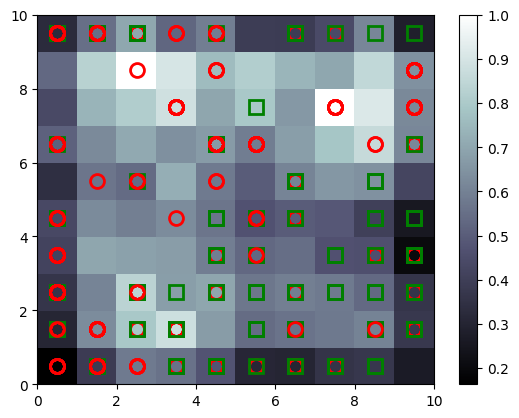

In [9]:
from pylab import bone, pcolor, colorbar, plot, show
bone()
pcolor(som.distance_map().T)
colorbar()
markers = ['o', 's']
colors = ['r', 'g']
for i, x in enumerate(X):
    w = som.winner(x)
    plot(w[0]+0.5, w[1]+0.5,
         markers[y[i]], markeredgecolor = colors[y[i]], markerfacecolor = 'None', 
         markersize = 10, markeredgewidth = 2)
show()

# Encontrar los fraudes

In [10]:
def find_frauds(som, X):
  # minisom ofrece un diccionario con todas las asignaciones diferentes de cada nodo ganador y los clientes asignados a él
  mappings = som.win_map(X)
  # Vamos a obtener los datos de clientes que están en el cuadrado blanco (máxima distancia media entre neuronas)
  # Vamos a encontrar los 2 máximos de la matriz de distancias
  # Por como recorreremos la matriz aquí no la transponemos
  distances = som.distance_map()
  maxTuples = np.array([(np.NaN, np.NaN, -np.Infinity), (np.NaN, np.NaN, -np.Infinity)])
  for i in range(distances.shape[0]):
    for j in range(distances.shape[1]):
      distance = distances[i][j]
      # Obtenemos el mínimo de los máximos encontrados hasta ahora y su índice
      k = np.argmin(maxTuples[:, 2])
      minMaxDistance = maxTuples[k]
      # Si la distancia es mayor al mínimo encontrado entonces sustituiremos ese mínimo con la nueva distancia
      if (distance > minMaxDistance[2]):
        maxTuples[k] = [i, j, distance]

  # Construimos un objeto de índice con las coordenadas de los máximos obtenidos anteriormente. Convertiremos a tupla esas coordenadas
  mappings_i = map(tuple, maxTuples[:, :-1])
  # Traemos los valores del diccionario de mappings a una lista
  mappings_list = [mappings.get(key) for key in mappings_i if mappings.get(key) != None]
  # Los concatenamos con numpy, en el eje 0 (ampliamos el array, los juntamos por fila)
  frauds = np.concatenate(mappings_list, axis = 0)
  return frauds


frauds = find_frauds(som, X)
# Aplicamos la desnormalización
frauds = sc.inverse_transform(frauds)

# Parte 2 - Trasladar el modelo de Deep Learning de no supervisado a supervisado


# Crear la matriz de características


In [11]:
# Quitamos las columnas de id del cliente y la de supervisión
customers = dataset.iloc[:, 1:-1].values

# Crear la variable dependiente

In [47]:
# # Código original
# is_fraud = np.zeros(len(dataset))
# for i in range(len(dataset)):
#     if dataset.iloc[i, 0] in frauds:
#         is_fraud[i] = 1

is_fraud = np.array([1. if dataset.iloc[i, 0] in frauds else 0. for vec in range(len(dataset))])

# Escalado de variables


In [48]:
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
customers = sc_X.fit_transform(customers)

# Parte 2 - Construir la RNA


# Importar Keras y librerías adicionales


In [49]:
from keras.models import Sequential
from keras.layers import Dense

# Inicializar la RNA


In [50]:
classifier = Sequential()

# Añadir las capas de entrada y primera capa oculta


In [51]:
# Simplificamos la red y ponemos 14 como la dimensión de entrada
classifier.add(Dense(units = 2, kernel_initializer = "uniform",  activation = "relu", input_dim = 14))

# Añadir la capa de salida


In [52]:
classifier.add(Dense(units = 1, kernel_initializer = "uniform",  activation = "sigmoid"))

# Compilar la RNA

In [53]:
classifier.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])

# Ajustamos la RNA al Conjunto de Entrenamiento


In [54]:
classifier.fit(customers, is_fraud,  batch_size = 1, epochs = 2)


Epoch 1/2
690/690 [==============================] - 2s 2ms/step - loss: 0.4889 - accuracy: 0.9957
Epoch 2/2
690/690 [==============================] - 1s 2ms/step - loss: 0.1643 - accuracy: 1.0000


# Predicción de los resultados de fraude

In [62]:
# Hacemos la predicción con la red
y_pred  = classifier.predict(customers)
# Creamos una matriz que una los índices de los clientes y la predicción, por columnas
# Pondremos el slice 0:1 para que devuelva un vector bidimensional, en este caso una matriz con una columna
y_pred = np.concatenate((dataset.iloc[:,0:1].values, y_pred), axis = 1)
# Ordenamos la matriz en función de la predicción, con argsort. Por defecto el orden es de menor a mayor, si queremos revertir el orden primero negaremos el vector
# (el más alto será el menos alto, el segundo más alto será el segundo menos alto...y así). OJO con el paréntesis al negar el array
y_pred = y_pred[(-y_pred[:,1]).argsort()]

22/22 [==============================] - 0s 1ms/step
